## Engineering Notebook

---

In this notebook, we analyze the extracted features, assessing the necessity of normalization. We also investigate possible feature selection techniques to reduce the dimensionality of the data.
The sections are organized as follows:

1. [Load Data](#Load-Data)
2. [Feature Analysis](#2.-Feature-Analysis)
    1. [Visualize Features](#2.1.-Visualize-Features)
    2. [Feature correlation](#2.2.-Feature-Correlation)
3. [Covariance analysis](#3-covariance-matrix-of-the-groups)
4. [Feature Selection](#4.-Feature-Selection)
5. [Outliers Detection](#5.-Outliers-Detection)
6. [Feature distribution](#6-Feature-Distribution)
7. [PCA](#7-PCA)
8. [Save the data](#8-Save-Data)



In [29]:
# import all the functions
import numpy as np
import os
import sys

sys.path.append("../")
import pandas as pd
from utils import remove_highly_correlated_features
from scipy.stats import spearmanr

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [30]:
# paths to the features and the labels
FEATURE_RAW_DIR = "../../features/raw/"
FEATURE_BAL_PRIOR_DIR = "../../features/balanced/priori/"
FEATURE_BAL_POSTERIOR_DIR = "../../features/balanced/posteriori/"
FEATURE_BAL_BOTH_DIR = "../../features/balanced/both/"

feature_files = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}

feature_names = {
    "30 MFCC": [f"MFCC {i}" for i in range(1, 31)],
    "12  Chroma": [f"Chroma {i}" for i in range(1, 13)],
    "70 CQT": [f"CQT {i}" for i in range(1, 71)],
    "40 RMS": [f"RMS {i}" for i in range(1, 42)],
    "40 Zero Crossing Rates": [f"Zero Crossing Rates {i}" for i in range(1, 42)],
    "40 Spectral Centroid": [f"Spectral Centroid {i}" for i in range(1, 42)],
    "60 Spectral Bandwidth": [f"Spectral Bandwidth {i}" for i in range(1, 62)],
    "40 Spectral Rolloff": [f"Spectral Rolloff {i}" for i in range(1, 42)],
}
names = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]

INTERVAL=2
SR=4000

In [31]:
def get_features_not_correlated_with_target(
    data_df: pd.DataFrame, threshold: float = 0.41
) -> pd.Index:
    # Importa le librerie necessarie
    p_values = []
    correlazione = []
    features = []
    # Calcola i coefficienti di correlazione di Kendall e i valori p per ogni coppia di colonne nel dataframe
    for col1 in data_df.columns:
        correlation, p_value = spearmanr(data_df[col1], data_df["label"])
        p_values.append(p_value)
        correlazione.append(correlation)
        features.append(col1)

    correlazione_df = pd.DataFrame(
        {"Feature": features, "Correlazione": correlazione, "P-value": p_values}
    )
    features_to_drop = correlazione_df[
        np.abs(correlazione_df["Correlazione"]) <= threshold
    ]["Feature"]

    return features_to_drop.to_list()


def remove_features_highly_correlated(
    data_df: pd.DataFrame, threshold: float = 0.7, max_corr_count: int = 2
) -> pd.Index:
    correlation_matrix = data_df.corr(method="spearman")
    correlation_matrix_no_target = data_df.drop(columns=["label"]).corr(
        method="spearman"
    )
    features_to_drop = remove_highly_correlated_features(
        correlation_matrix,
        correlation_matrix_no_target,
        threshold=threshold,
        max_corr_count=max_corr_count,
    )
    return features_to_drop


def get_samples(file_path: str, names: list):
    dataset = []
    if ("posterior" in file_path) or ("both" in file_path):
        data = np.load(file_path, allow_pickle=True).item()
        data = data["train_bal"]
        X = data["X"]
        y = data["y"].reshape(-1, 1)
        dataset = np.concatenate((X, y), axis=1)
    else:
        data_list = []
        for name in names:
            data = np.load(file_path, allow_pickle=True).item()
            data = data[name]
            X = data["X"]
            y = data["y"].reshape(-1, 1)
            data_combined = np.concatenate((X, y), axis=1)
            data_list.append(data_combined)
        dataset = np.concatenate(data_list, axis=0)
    return dataset


def read_file(file_path: str):

    dataset = []  # Initialize an empty list to store dataset
    data = None  # Initialize data to None

    # Check if the file path indicates posterior or both types of data
    if ("posterior" in file_path) or ("both" in file_path):
        # Load the data from the file and extract the "train_bal" subset
        data = np.load(file_path, allow_pickle=True).item()
        datam = data["train_bal"]

        # Separate features (X) and labels (y), then concatenate them into one array
        X = datam["X"]
        y = datam["y"].reshape(-1, 1)
        dataset = np.concatenate((X, y), axis=1)
    else:
        # Initialize a list to store data from multiple names
        data_list = []

        # Iterate over each name in names
        for name in names:
            # Load the data from the file and extract the subset for the current name../../features/raw/70cqt
            data = np.load(file_path, allow_pickle=True).item()
            datam = data[name]

            # Separate features (X) and labels (y), then concatenate them into one array
            X = datam["X"]
            y = datam["y"].reshape(-1, 1)
            data_combined = np.concatenate((X, y), axis=1)
            data_list.append(data_combined)  # Add the combined data to the list

        # Concatenate all data from the list into one dataset
        dataset = np.concatenate(data_list, axis=0)

    # Convert the dataset into a pandas DataFrame with feature names and label
    data_df = pd.DataFrame(dataset, columns=feature_names[feature_name] + ["label"])

    return data, data_df


def remove_features(data, data_df, features_to_drop, file_path):
    # Drop the identified features from the dataset
    indexes = data_df.columns.get_indexer(features_to_drop)
    print("Removing features from the dataset")
    filtered_data = data
    # Check if the file path indicates posterior or both types of data
    if ("posterior" in file_path) or ("both" in file_path):
        # Load the data from the file and extract the "train_bal" subset
        for key in filtered_data.keys():
            filtered_data[key]["X"] = np.delete(
                filtered_data[key]["X"], indexes, axis=1
            )
    else:
        # Iterate over each name in names
        for name in names:
            # Load the data from the file and extract the subset for the current name
            filtered_data[name]["X"] = np.delete(
                filtered_data[name]["X"], indexes, axis=1
            )
    return filtered_data

### 1. Load Data <a id='Load-Data'></a>


In [32]:
# List of folders to process, each corresponding to a different feature set.
FOLDERS = [
    FEATURE_RAW_DIR,
    FEATURE_BAL_PRIOR_DIR,
    FEATURE_BAL_POSTERIOR_DIR,
    FEATURE_BAL_BOTH_DIR,
]
info_df = pd.DataFrame(
    columns=[
        "Folder",
        "Feature Name",
        "Number of Features",
        "Not much correlated with target",
        "Highly correlated with each other",
        "Features to drop",
    ]
)
# Iterate over each folder in FOLDERS
for folder in FOLDERS:
    # Iterate over each feature name and corresponding file in feature_files
    for feature_name, feature_file in feature_files.items():
        print(f"Processing {feature_name} in {folder}{feature_file}")

        # Construct the full file path for the current feature file
        file_path = os.path.join(
            folder, f"full_data_{INTERVAL}s_{SR}hz_{feature_file}.npy"
        )

        data, data_df = read_file(file_path)
        n_features = data_df.shape[1] - 1
        # Identify features that are not correlated with the target
        features_not_correlated = get_features_not_correlated_with_target(
            data_df, threshold=0.3
        )
        print(
            f"Features not correlated with the target : {len(features_not_correlated)}"
        )
        print(f"Features not correlated with the target", features_not_correlated)
        # Identify features that are highly correlated with each other
        features_highly_correlated = remove_features_highly_correlated(
            data_df, threshold=0.85, max_corr_count=6
        )
        print(
            f"Features highly correlated with each other : {len(features_highly_correlated)}"
        )
        print(f"Features highly correlated with each other", features_highly_correlated)
        # Combine features to drop from both uncorrelated and highly correlated sets
        features_to_drop = list(
            set(features_highly_correlated + features_not_correlated)
        )

        print(f"Number of features to drop :  {len(features_to_drop)}")
        print(f"Features to drop", features_to_drop)
        # Drop the identified features from the dataset
        filtered_data = remove_features(data, data_df, features_to_drop, file_path)

        # print("Saving filtered data")
        # # Construct the full file path for the current feature file
        # save_file_path = os.path.join(
        #     folder, f"full_data_filtered_{INTERVAL}s_{SR}hz_{feature_file}.npy"
        # )
        # np.save(save_file_path, filtered_data)

        new_row = {
            "Folder": folder.split("/")[-2],
            "Feature Name": feature_name,
            "Number of Features": data_df.shape[1] - 1,
            "Not much correlated with target": len(features_not_correlated),
            "Highly correlated with each other": len(features_highly_correlated),
            "Features to drop": len(features_to_drop),
        }

        # Adding the new row
        info_df.loc[len(info_df)] = new_row

Processing 30 MFCC in ../../features/raw/30mfcc
Features not correlated with the target : 17
Features not correlated with the target ['MFCC 7', 'MFCC 9', 'MFCC 11', 'MFCC 13', 'MFCC 14', 'MFCC 15', 'MFCC 16', 'MFCC 17', 'MFCC 18', 'MFCC 19', 'MFCC 20', 'MFCC 21', 'MFCC 22', 'MFCC 24', 'MFCC 26', 'MFCC 29', 'MFCC 30']
Removing 0 features
Features highly correlated with each other : 0
Features highly correlated with each other []
Number of features to drop :  17
Features to drop ['MFCC 9', 'MFCC 16', 'MFCC 30', 'MFCC 17', 'MFCC 20', 'MFCC 13', 'MFCC 22', 'MFCC 14', 'MFCC 26', 'MFCC 21', 'MFCC 18', 'MFCC 7', 'MFCC 24', 'MFCC 29', 'MFCC 15', 'MFCC 11', 'MFCC 19']
Removing features from the dataset
Processing 12  Chroma in ../../features/raw/12chroma
Features not correlated with the target : 1
Features not correlated with the target ['Chroma 11']
Removing 0 features
Features highly correlated with each other : 0
Features highly correlated with each other []
Number of features to drop :  1
F

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5]),
 [Text(0, 0.5, 'raw-70 CQT'),
  Text(0, 1.5, 'posteriori-70 CQT'),
  Text(0, 2.5, 'priori-70 CQT'),
  Text(0, 3.5, 'both-70 CQT'),
  Text(0, 4.5, 'priori-60 Spectral Bandwidth'),
  Text(0, 5.5, 'posteriori-60 Spectral Bandwidth'),
  Text(0, 6.5, 'raw-60 Spectral Bandwidth'),
  Text(0, 7.5, 'both-60 Spectral Bandwidth'),
  Text(0, 8.5, 'priori-40 Zero Crossing Rates'),
  Text(0, 9.5, 'raw-40 Zero Crossing Rates'),
  Text(0, 10.5, 'posteriori-40 Zero Crossing Rates'),
  Text(0, 11.5, 'both-40 Zero Crossing Rates'),
  Text(0, 12.5, 'priori-40 Spectral Rolloff'),
  Text(0, 13.5, 'both-40 Spectral Rolloff'),
  Text(0, 14.5, 'raw-40 Spectral Rolloff'),
  Text(0, 15.5, 'posteriori-40 Spectral Rolloff'),
  Text(0, 16.5, 'priori-40 Spectral Centroid'),
  Text(0, 17.5, 'both-40 Spe

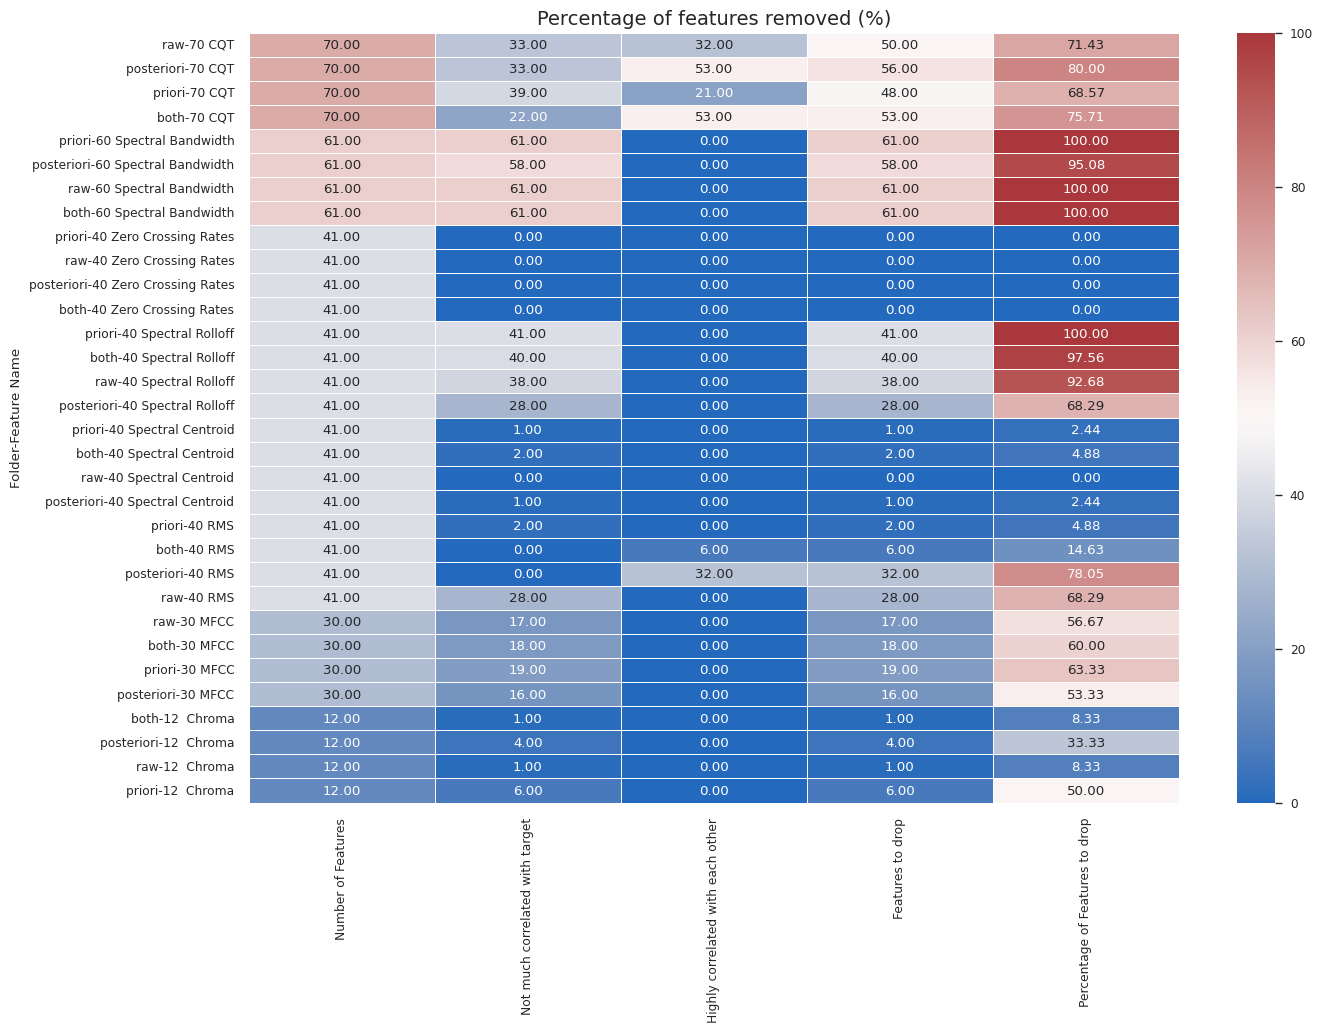

In [33]:
info_df["Percentage of Features to drop"] = (
    info_df["Features to drop"] / info_df["Number of Features"]
) * 100

info_df.sort_values("Feature Name", ascending=False, inplace=True)
info_df[info_df["Percentage of Features to drop"] >= 70]
info_df.set_index(
    [
        "Folder",
        "Feature Name",
    ], inplace=True
)

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(
    info_df,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    vmax=100,
    vmin=0,
    linewidths=0.5,
)
plt.title("Percentage of features removed (%)", fontsize=14)
plt.yticks(rotation=0)

### 2. Feature Analysis


#### Compute the correlation coefficient between the features and the target variable.
